In [1]:
import numpy as np
from Bio import Phylo
from io import StringIO
from scipy.special import comb
from utilities import *

np.random.seed(42)

In [21]:
class GenSimulator():
    """
    Base class that provide simulation for one genom
    population_size_over_time - times when change lambda
    """
    def __init__(self, number_of_descendants: int, 
                 population_size_over_time: list,
                 mutation_rate: int,
                 lambda_distributation: list):
        self.number_of_descendants = number_of_descendants
        self.lambda_distributation = lambda_distributation
        self.population_size_over_time = population_size_over_time
        self.mutation_rate = mutation_rate
        
        self.poisson_rate = number_of_descendants*mutation_rate + comb(number_of_descendants,2)/lambda_distributation[0]
        
        self.current_population = {}
        self.tree = None
        self.table = {}
    
    
    def init_population(self):
        for i in range(self.number_of_descendants):
            name = generate_name()
            while name in self.current_population.keys(): name = generate_name()
            self.current_population[name] = "{}:{}".format(name, '{}')
            
    def do_event(self, event_type, *args):
        if event_type == 'coalescence':
            self.do_coalescence(*args)
        elif event_type == 'mutation':
            self.do_mutation(*args)
        else:
            raise 'Type not in list'
    
    def do_coalescence(self, current_linage_number, t, delta_t):
        #print('coalescence')
        name_1 = np.random.choice(list(self.current_population.keys()))
        name_2 = np.random.choice(list(self.current_population.keys()))
        while name_1 == name_2: name_2 = np.random.choice(list(self.current_population.keys()))
        left = self.current_population.pop(name_1)
        right = self.current_population.pop(name_2)
        new_name = '{}_{}'.format(name_1, name_2)
        new_branch = '(' + left + ',' + right + ')'
        self.current_population[new_name] =  new_branch.format(delta_t, delta_t)
    
    def do_mutation(self, current_linage_number, t, delta_t):
        #print('mutation')
        position = np.random.uniform()
        while position in self.table.keys(): position = np.random.uniform()
        name = np.random.choice(list(self.current_population.keys()))
        self.table[position] = name
        
    def generate(self):
        self.init_population()
        t = 0
        i = 0
        current_limit = self.population_size_over_time[i]
        current_linage_number = self.number_of_descendants
        
        while current_linage_number > 1:
            #print(len(self.current_population))
            generated_t = np.random.poisson(self.poisson_rate)
            if generated_t > current_limit and i < len(self.population_size_over_time) - 1:
                # Nothing happens in this intervals
                i = i + 1
                t = current_limit
                current_limit = self.population_size_over_time[i]
                self.poisson_rate = current_linage_number*self.mutation_rate + comb(current_linage_number,2)/self.lambda_distributation[i+1]
                continue
            else:
                t = t + generated_t
                # Chose what happens - mutation or coalesent
                s = current_linage_number*self.mutation_rate + comb(current_linage_number,2)/self.lambda_distributation[i+1]
                event_type = np.random.choice(
                    ['mutation', 'coalescence'],
                    p=[current_linage_number*self.mutation_rate/s,
                       (comb(current_linage_number,2)/self.lambda_distributation[i+1])/s]
                )
                self.do_event(event_type, current_linage_number, t, generated_t)
                current_linage_number = len(self.current_population)
                self.poisson_rate = current_linage_number*self.mutation_rate + comb(current_linage_number,2)/self.lambda_distributation[i+1]
        for tree in self.current_population.values():
            self.tree = tree
    
    def __call__(self):
        if self.tree is None:
            raise "Firstly need to be generated"
        return self.tree, self.table
    

In [22]:
lam_time = [6,12]
lam = [3,1,3]
mr = .25

In [24]:
test = GenSimulator(100, lam_time, mr, lam)
test.generate()
tree_str,mutation = test()

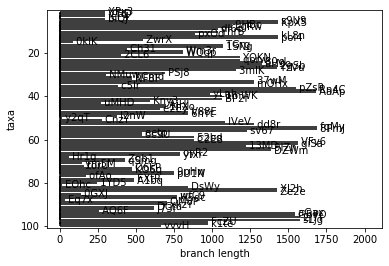

In [25]:
s = StringIO(tree_str)
tree = Phylo.read(s, "newick")
Phylo.draw(tree)

In [31]:
def plot_tree(treedata):
    #handle = StringIO(treedata)  # parse the newick string
    tree = Phylo.read(treedata, "newick")
    matplotlib.rc('font', size=60)
    # set the size of the figure
    fig = plt.figure(figsize=(100, 200), dpi=100)
    # alternatively
    # fig.set_size_inches(10, 20)
    axes = fig.add_subplot(1, 1, 1)
    Phylo.draw(tree, axes=axes)
    return

In [32]:
s = StringIO(tree_str)
plot_tree(s)